C:\Users\ASUS\AppData\Local\Temp\ipykernel_3024\2404821292.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  p2_estimate = (1 / p2_estimate[2]) * p2_estimate
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3024\2404821292.py:68: RuntimeWarning: invalid value encountered in multiply
  p2_estimate = (1 / p2_estimate[2]) * p2_estimate


[[-1.01878285e+00 -1.74796347e+00  5.93705922e+02]
 [-1.40934765e+00 -2.25984154e+00  7.25784706e+02]
 [-1.66424239e-03 -3.87984549e-03  1.00000000e+00]]


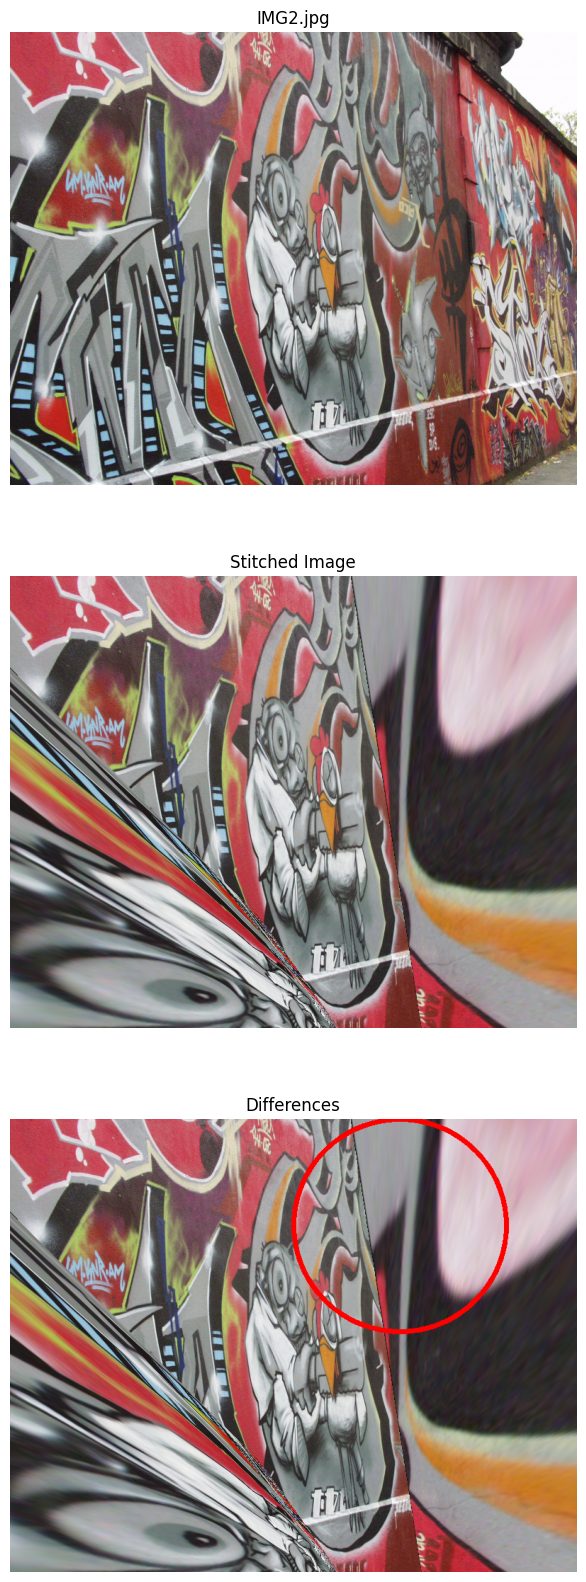

In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
# Detect keypoints and compute descriptors for both images using SIFT
sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.08, edgeThreshold=12, sigma=0.9)

#Loading the images
IMG2 = cv.imread('img5.ppm')
IMG1 = cv.imread('img1.ppm')

key_points_1, Descriptor_1 = sift.detectAndCompute(IMG1, None)
key_points_2, Descriptor_2 = sift.detectAndCompute(IMG2, None)

# Create a Brute-Force Matcher and perform keypoint matching
bf = cv.BFMatcher()
matches = bf.knnMatch(Descriptor_1, Descriptor_2, k=2)
good, POINTS1, POINTS2 = [], [], []

# Apply the ratio test to filter good matches and extract corresponding keypoints
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])
        POINTS1.append(key_points_1[m.queryIdx].pt)
        POINTS2.append(key_points_2[m.trainIdx].pt)

# Convert lists to NumPy arrays for further processing
good, POINTS1, POINTS2 = np.array(good), np.array(POINTS1), np.array(POINTS2)

# Draw the good matches
matched_img = cv.drawMatchesKnn(IMG1, key_points_1, IMG2, key_points_2, good[:50], None, flags=2)

# Define a function to compute the homography matrix
def homography(POINTS1, POINTS2):
    # Calculate mean and scaling factors for normalization
    mean1, mean2 = np.mean(POINTS1, axis=0), np.mean(POINTS2, axis=0)
    s1, s2 = len(POINTS1) * np.sqrt(2) / np.sum(np.sqrt(np.sum((POINTS1 - mean1) ** 2, axis=1))), len(POINTS1) * np.sqrt(2) / np.sum(np.sqrt(np.sum((POINTS2 - mean2) ** 2, axis=1)))

    # Compute the transformation matrices
    tx1, ty1, tx2, ty2 = -s1 * mean1[0], -s1 * mean1[1], -s2 * mean2[0], -s2 * mean2[1]
    T1, T2 = np.array(((s1, 0, tx1), (0, s1, ty1), (0, 0, 1))), np.array(((s2, 0, tx2), (0, s2, ty2), (0, 0, 1)))
    A = []

    # Construct the matrix A for solving the linear system
    for i in range(len(POINTS1)):
        X11, X21 = T1 @ np.concatenate((POINTS1[i], [1])).reshape(3, 1), T2 @ np.concatenate((POINTS2[i], [1])).reshape(3, 1)
        A.append((-X11[0][0], -X11[1][0], -1, 0, 0, 0, X21[0][0] * X11[0][0], X21[0][0] * X11[1][0], X21[0][0]))
        A.append((0, 0, 0, -X11[0][0], -X11[1][0], -1, X21[1][0] * X11[0][0], X21[1][0] * X11[1][0], X21[1][0]))

    A = np.array(A)

    # Solve the linear system using SVD
    U, S, V = np.linalg.svd(A, full_matrices=True)
    h = np.reshape(V[-1], (3, 3))

    # Normalize the homography matrix and return
    H = linalg.inv(T2) @ h @ T1
    H = (1 / H.item(8)) * H

    return H

# Define a function to compute the Euclidean distance between two points after applying the homography
def dist(P1, P2, H):
    p1 = np.array([P1[0], P1[1], 1])
    p2 = np.array([P2[0], P2[1], 1])

    p2_estimate = np.dot(H, p1.T)
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate

    return np.linalg.norm(p2.T - p2_estimate)

# Define a function for RANSAC-based homography estimation
def RANSAC_homography(points1, points2):
    inlier_count, selected_inliers = 0, None
    points = np.hstack((points1, points2))

    # Calculate the number of iterations based on the probability of outlier detection
    NUMBER_of_ITERATIONS = 10000#int(np.log(1 - 0.95) / np.log(1 - (1 - 0.5) ** 4))

    for _ in range(NUMBER_of_ITERATIONS):
        np.random.shuffle(points)
        POINTS1, POINTS1_rem, POINTS2, POINTS2_rem = points[:4, :2], points[4:, :2], points[:4, 2:], points[4:, 2:]
        H = homography(POINTS1, POINTS2)
        inliers = [(POINTS1_rem[i], POINTS2_rem[i]) for i in range(len(POINTS1_rem)) if dist(POINTS1_rem[i], POINTS2_rem[i], H) < 100]

        if len(inliers) > inlier_count:
            inlier_count = len(inliers)
            selected_inliers = np.array(inliers)

    # Compute the final homography matrix using the selected inliers
    H = homography(selected_inliers[:, 0], selected_inliers[:, 1])

    return H

# Call the RANSAC-based homography estimation function
H = RANSAC_homography(POINTS1, POINTS2)

# Print the computed homography matrix
print(H)

# Convert the list of tuples to a NumPy array
H = np.array(H)

# Warp IMG1 using the perspective transformation matrix H to match the shape of IMG2
img_p = cv.warpPerspective(IMG1, H, (IMG2.shape[1], IMG2.shape[0]))

# Threshold the warped image to create a binary mask
# Pixels with values above 10 become 1, and pixels below 10 become 0 (inverted)
ret, threshold = cv.threshold(img_p, 10, 1, cv.THRESH_BINARY_INV)

# Multiply the binary mask with IMG2 to extract the common region
IMG2_THRESHOLD = np.multiply(threshold, IMG2)

# Blend the thresholded image with the warped image
BLENDED_IMG = cv.addWeighted(IMG2_THRESHOLD, 1, img_p, 1, 0)

# Create a figure with three subplots for visualization
fig, ax = plt.subplots(3,1, figsize=(20, 20))

# Display IMG2
ax[0].imshow(cv.cvtColor(IMG2, cv.COLOR_BGR2RGB))
ax[0].set_title("IMG2.jpg")
ax[0].axis("off")

# Display the stitched image
ax[1].imshow(cv.cvtColor(BLENDED_IMG, cv.COLOR_BGR2RGB))
ax[1].set_title("Stitched Image")
ax[1].axis("off")

# Add a circle to highlight the difference between the images
BLENDED_IMG = cv.circle(BLENDED_IMG, (550, 150), 150, (0, 0, 255), 5)

# Display the image with the circle
ax[2].imshow(cv.cvtColor(BLENDED_IMG, cv.COLOR_BGR2RGB))
ax[2].set_title("Differences")
ax[2].axis("off")

# Show the figure with the subplots
plt.show()